In [1]:
!pip install pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.7/727.7 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 46.4 MB/s eta 0:00:00


In [2]:
import pytorch_lightning as pl
import random
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import (DataLoader, RandomSampler, TensorDataset, random_split)
import torch.nn.functional as F
import torchvision.utils as utils
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from matplotlib import pyplot as plt

In [3]:
config = {
    'LATENT_SIZE':100,
    'HIDDEN_SIZE':256,
    'OUTPUT_SIZE':1,
    'EPOCHS':200,
    'LEARNING_RATE':0.0002,
    'BATCH_SIZE':128,
    'HEIGHT':28,
    'WIDTH':28,
    'CHANNEL':1,
    'SEED':42
}

In [4]:
class MNISTDataModule(pl.LightningDataModule):

    def __init__(self,config,data_dir: str = '/content/'):
        super().__init__()
        self.data_dir = data_dir
        self.transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(0.5, 0.5)])
        self.config = config

    def prepare_data(self):
        datasets.MNIST(self.data_dir,train=True,download=True)
        datasets.MNIST(self.data_dir,train=False,download=True)


    def setup(self, stage: str):

        # Assign train/val datasets for use in dataloaders
        if stage == "fit":
            self.mnist_full = datasets.MNIST(self.data_dir, train=True, transform=self.transform)


    def train_dataloader(self):
        return DataLoader(self.mnist_full, batch_size=config['BATCH_SIZE'])


In [5]:
class Generator(nn.Module):

  def __init__(self, config):
    super(Generator, self).__init__()

    # 입력층 노드 수
    self.inode = config["LATENT_SIZE"] # 28x28보다 작거나 같다? Z
    # 은닉층 노드 수
    self.hnode = config["HIDDEN_SIZE"]
    # 출력층 노드 수: 생성해야 하는 노드 수
    self.onode = config["HEIGHT"] * config['WIDTH'] # 28x28

    # 신경망 설계
    self.net = nn.Sequential(nn.Linear(self.inode, self.hnode, bias=True),
                             nn.LeakyReLU(),
                             nn.Dropout(0.1),
                             nn.Linear(self.hnode, self.hnode, bias=True),
                             nn.LeakyReLU(),
                             nn.Dropout(0.1),
                             nn.Linear(self.hnode, self.hnode, bias=True),
                             nn.LeakyReLU(),
                             nn.Dropout(0.1),
                             nn.Linear(self.hnode, self.onode, bias=True),
                             nn.Tanh())

  def forward(self, input_features):
    hypothesis = self.net(input_features)
    hypothesis = hypothesis.view(hypothesis.size(0),-1)
    return hypothesis

In [6]:
class Discriminator(nn.Module):

  def __init__(self, config):
    super(Discriminator, self).__init__()

    # 입력층 노드 수
    self.inode = config["HEIGHT"] * config['WIDTH'] # 28x28
    # 은닉층 노드 수
    self.hnode = config["HIDDEN_SIZE"]
    # 출력층 노드 수: 분류해야 하는 레이블 수
    self.onode = config["OUTPUT_SIZE"] # real? fake?

    # 신경망 설계
    self.net = nn.Sequential(nn.Linear(self.inode, self.hnode, bias=True),
                             nn.LeakyReLU(),
                             nn.Dropout(0.1),
                             nn.Linear(self.hnode, self.hnode, bias=True),
                             nn.LeakyReLU(),
                             nn.Dropout(0.1),
                             nn.Linear(self.hnode, self.hnode, bias=True),
                             nn.LeakyReLU(),
                             nn.Dropout(0.1),
                             nn.Linear(self.hnode, self.onode, bias=True),
                             nn.Sigmoid())

  def forward(self, input_features):
    hypothesis = self.net(input_features)
    return hypothesis

In [7]:
class GAN(pl.LightningModule):
    def __init__(self,config):
        super(GAN,self).__init__()

        self.config = config
        self.G = Generator(config)
        self.D = Discriminator(config)
        self.automatic_optimization = False

    def forward(self, z):
        return self.G(z)


    def get_noise(self,batch_size):
        return torch.randn(batch_size, self.config['LATENT_SIZE'])

    def imshow(self, img):
        img = (img+1)/2
        img = img.squeeze()
        np_img = img.numpy()
        plt.imshow(np_img, cmap='gray')
        plt.show()

    def imshow_grid(self,img):
        img = utils.make_grid(img.cpu().detach())
        img = (img+1)/2
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1,2,0)))
        plt.show()

    def loss(self, y_hat,y):
        return F.binary_cross_entropy(y_hat,y)

    def configure_optimizers(self):
        optimizer_G = optim.Adam(self.G.parameters(),lr = config['LEARNING_RATE'],betas=(0.9,0.999))
        optimizer_D = optim.Adam(self.D.parameters(),lr = config['LEARNING_RATE'],betas=(0.9,0.999))
        return [optimizer_G,optimizer_D]

    def training_step(self, batch, batch_idx):
        imgs, _ = batch

        batch_size = imgs.shape[0]
        imgs = imgs.view(batch_size,-1)

        optimizers = self.optimizers()
        opt_G,opt_D = optimizers[0],optimizers[1]

        real_label = torch.ones((batch_size,1))
        real_label = real_label.type_as(imgs) #이런식으로도 device 변경가능
        fake_label = torch.zeros((batch_size,1),device=self.device) #이런식으로도 가능

        # noise sample
        z = self.get_noise(batch_size)
        z = z.type_as(imgs) # dynamic 하게 device를 변경시켜줌

        G_x = self(z)

        # discriminator

        #real image
        D_x = self.D(imgs)
        D_loss = self.loss(D_x,real_label)

        #fake image
        D_z = self.D(G_x.detach())
        Z_loss = self.loss(D_z,fake_label)

        total_loss = D_loss + Z_loss

        opt_D.zero_grad()
        self.manual_backward(total_loss)
        opt_D.step()

        # generator

        D_z = self.D(G_x)
        G_loss = self.loss(D_z,real_label)

        opt_G.zero_grad()
        self.manual_backward(G_loss)
        opt_G.step()

        return {'D_loss':total_loss,'G_loss':G_loss}

    def on_train_epoch_end(self):

        if self.current_epoch % 10 == 0:
            z = self.get_noise(16)
            z = z.type_as(self.G.net[0].weight)

            generate_imgs = self(z)
            generate_imgs_ = generate_imgs.reshape((-1,28,28)).unsqueeze(1)
            self.imshow_grid(generate_imgs_)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


100%|██████████| 9912422/9912422 [00:00<00:00, 111960401.15it/s]


Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 105152512.00it/s]

Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 23473538.89it/s]


Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 18806050.12it/s]

Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw




INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type          | Params
---------------------------------------
0 | G    | Generator     | 358 K 
1 | D    | Discriminator | 332 K 
---------------------------------------
691 K     Trainable params
0         Non-trainable params
691 K     Total params
2.767     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

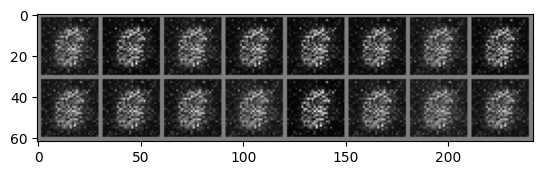

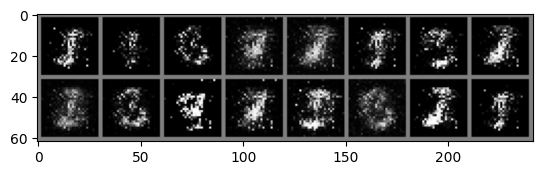

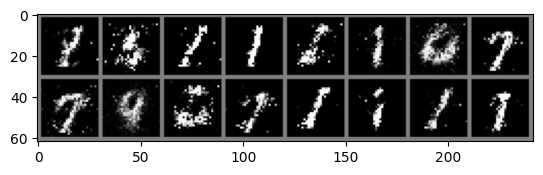

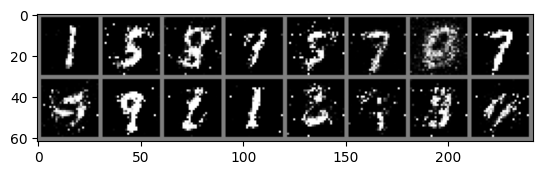

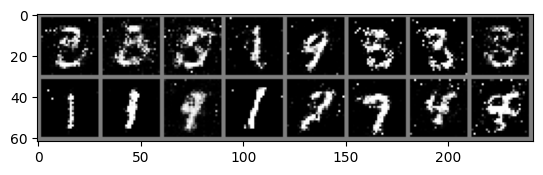

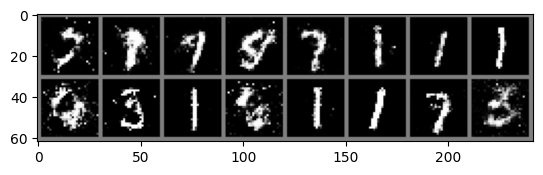

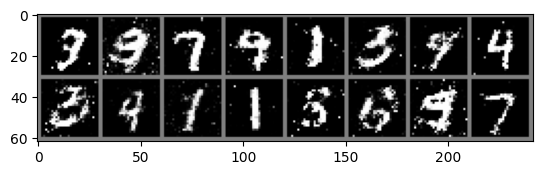

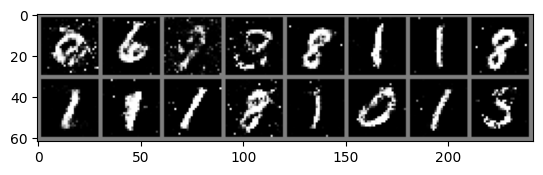

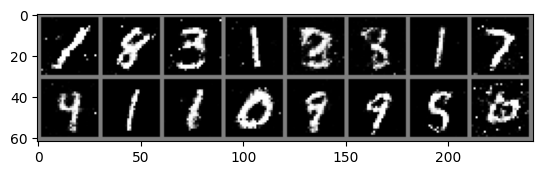

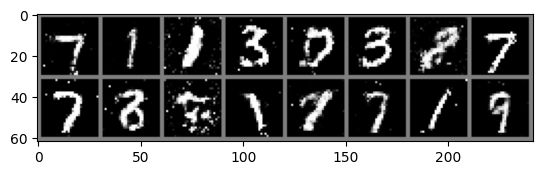

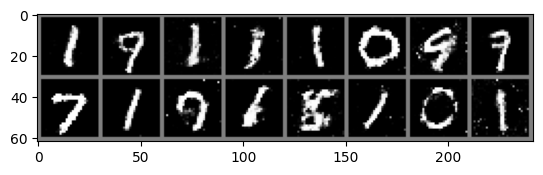

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/call.py:53: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [8]:
dm = MNISTDataModule(config)
model = GAN(config)
trainer = pl.Trainer(accelerator='auto',devices='auto',max_epochs=config['EPOCHS'],callbacks=[pl.callbacks.progress.TQDMProgressBar(refresh_rate=20)])
trainer.fit(model,dm)